In [123]:
import numpy as np
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
from google.colab import files
import pickle
from sklearn.linear_model import LinearRegression
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
import math

# algorithm settings
max_bat_energy = 770 #1800 #770 #1800  # Watts hours
max_thruster_p = 50   # Watts
population_size = 1000
crossover_probability = 0.7
mutation_probability = 0.2
hours_per_day = 24
population = []
n_generation = 15

# mission settings
t_mission = 24    # no of hours to end mission
d_mission = 36581 #50000 # no of meters of the linear path
current_solar_power = 63.57*1000   # in mW
current_hour = 10
start_battery = 583 #1605.065 #583 #1605.065
p_sensor = []
for i in range(hours_per_day):
  p_sensor.append(35.5)

In [124]:
# 24-hr solar predictor (using LSTM) 
def solar_predictor(current_solar_power, current_hour):
  # step 1: load the training data
  data = pd.read_csv("solar.csv")
  timestamp = data['timestamp']
  year = []
  month = []
  day = []
  time = []
  hour = []
  minute = []
  for dt in timestamp:
    x = dt.split()
    time.append(x[1])
    z = x[1].split(':')
    hour.append(int(z[0]))
    minute.append(int(z[1]))
    y = x[0].split('.')
    day.append(int(y[0]))
    month.append(int(y[1]))
    year.append(int(y[2]))
  data['hour'] = hour

  # step 2: fit the transformers
  scalerX = MinMaxScaler(feature_range=(0, 1))
  scalerH = MinMaxScaler(feature_range=(0, 1))
  hour = data['hour'].to_numpy()
  power = data['solar_power'].to_numpy()
  hour_set = scalerH.fit_transform(np.array(hour).reshape(-1,1))
  power_set = scalerX.fit_transform(np.array(power).reshape(-1,1))

  # step 3: make the predictions
  model = Sequential()
  model.add(LSTM(4, input_shape=(1,2)))
  model.add(Dense(1))
  model.load_weights("solar_model_enhanced.h5")

  predicted = [current_solar_power]
  h = current_hour
  p = current_solar_power
  for i in range(hours_per_day - 1):
    scaled_power = scalerX.transform(np.array([p]).reshape(-1,1))
    scaled_hour = scalerH.transform(np.array([h]).reshape(-1,1))
    prediction = model.predict(np.array([scaled_power, scaled_hour]).reshape(-1,1,2))
    s = scalerX.inverse_transform(prediction.reshape(-1,1))[0,0]
    if s < 0 or (h>20) or (h<5):
      predicted.append(0)
    else:
      predicted.append(s)
    p = predicted[i+1]
    h = (h+1)%24
  return predicted

#print(solar_predictor(72279, 14))

In [125]:
# 24-hr battery energy predictor
# each input with p_* means an array of 25 values
# for example: p_thruster = [p_thruster(t), p_thruster(t+1), ..., p_thruster(t+24)]
def battery_energy_predictor(e_battery, p_thruster, p_solar, p_sensor):
  battery_forecast = [e_battery]
  
  assert len(p_thruster) == len(p_solar) == len(p_sensor)
  for i in range(len(p_thruster)-1):
    p_load_1 = p_sensor[i] + p_thruster[i]
    p_charging_1 = p_solar[i] - p_load_1
    
    p_load_2 = p_sensor[i+1] + p_thruster[i+1]
    p_charging_2 = p_solar[i+1] - p_load_2

    delta_e = (p_charging_2 + p_charging_1)/2
    value = battery_forecast[i]+delta_e
    if value > max_bat_energy:
      value = max_bat_energy
    battery_forecast.append(value)
  return battery_forecast

def test():
  p_thruster = [0, 10, 20, 30, 40, 50]
  p_solar = [60, 80, 40, 20, 10, 0]
  p_sensor = [10, 10, 10, 10, 10, 10]
  return battery_energy_predictor(100, p_thruster, p_solar, p_sensor)
  
#print(test())

In [126]:
# get wave height forecasts from weather forecast
def wave_predictor():
  data = pd.read_csv('real_mission.csv')
  return data['Hs'].to_numpy(), data['T'].to_numpy()

#print(wave_predictor())

In [127]:
# speed predictor for WG
# assumption: input data is array
def speed_predictor(wave_height, wave_period, thruster_power):
  filename = "speed_model_knn.sav"
  loaded_model = pickle.load(open(filename, 'rb'))
  assert len(wave_height) == len(wave_period) == len(thruster_power)
  X = []
  for i in range(len(wave_height)):
    X.append([wave_height[i], wave_period[i], thruster_power[i]])
  
  raw_data = pd.read_csv('sim_data.csv')
  x = raw_data[['Hs', 'T', 'Pth']]
  scaler = MinMaxScaler(feature_range=(0, 1))
  x = scaler.fit_transform(x.values)
  result = loaded_model.predict(scaler.transform(X))
  #print(scaler.transform(X))
  return result

h = [0.2, 0.3, 0.1]
t = [4, 5, 3]
p = [30, 0, 50]
#print(speed_predictor(h,t,p))

In [128]:
# compute desired speed
def desired_speed_prediction():
  avg_speed = d_mission / (t_mission*60*60)   # unit is m/s
  return np.ones(hours_per_day) * avg_speed

#desired_speed_prediction()

In [129]:
# genetic algorithm fitness function

def fitness_fucntion(desired_speed, battery_forecast, speed_forecast, distance_penality=True):
  assert len(desired_speed) == len(battery_forecast) == len(speed_forecast)
  sum = 0
  for i in range(len(desired_speed) - 1):
    #if(battery_forecast[i+1]) < 0:
      #sum = sum + -999999
      #break

    b_value = 0.8*(battery_forecast[i+1]/max_bat_energy)
    t_value = 0.2*(speed_forecast[i+1]/desired_speed[i+1])
    sum = sum + b_value + t_value

    # distance penality
    if distance_penality:
      distance = np.array(speed_forecast.sum()*60*60)
      if distance > d_mission:
        sum = sum * math.exp(-(distance-d_mission)/100)
  return sum

def test():
  desired_speed = [0.5,0.5,1,1,2,2]
  battery_forecast = [120, 150, 140, 120, 80, 30]
  speed_forecast = [0.5, 0.9, 0.1, 0.0, 0.3, 0.0]
  return fitness_fucntion(desired_speed, battery_forecast, speed_forecast)
  
#print(test())

In [130]:
# sort population according to their fitness

def sort_population(population, fitness_values):
  sorted_population = population
  sorted_fitness_values = fitness_values
  for i in range(len(population)):
    largest = i
    for j in range(i+1, len(population)):
      if sorted_fitness_values[j] > sorted_fitness_values[largest]:
        largest = j

    temp = sorted_population[i]
    sorted_population[i] = sorted_population[largest]
    sorted_population[largest] = temp

    temp = sorted_fitness_values[i]
    sorted_fitness_values[i] = sorted_fitness_values[largest]
    sorted_fitness_values[largest] = temp
  
  return sorted_population, sorted_fitness_values

def test():
  pop = ['a', 'b', 'c', 'x', 'y']
  fit = [5, 3, 9, 8, 1]
  s, f = sort_population(pop, fit)
  print(s)
  print(f)

#test()

In [131]:
# convert fitness into probabilities

def fitness_to_percentage(fitness_values):
  sum = np.array(fitness_values).sum()
  percentage = []
  pre_value = 0
  for value in fitness_values:
    percentage.append(pre_value + value/float(sum))
    pre_value = pre_value + value/float(sum)
  return percentage

def test():
  pop = ['a', 'b', 'c', 'x', 'y']
  fit = [5, 3, 9, 8, 20]
  prob = fitness_to_percentage(fit)

  # monte carlo simulation
  counts = np.zeros(len(prob))
  for i in range(1000):
    p = random.random()
    for j in range(len(prob)):
      if p <= prob[j]:
        counts[j] = counts[j] + 1
        break
  print(counts/counts.sum())
  fit = np.array(fit)
  print(fit/fit.sum())

#test()

In [132]:
# initalize population
def initialize_population():
  return np.random.rand(population_size, hours_per_day)*max_thruster_p

#initialize_population()
#print(population)

In [133]:
# compute fitness based on models

def compute_fitness(population, waves, period, solar, desired_speed, e_battery):
  fitness_values = []
  for parent in population:
    speed_forecast = speed_predictor(waves, period, parent)
    battery_forecast = battery_energy_predictor(e_battery, parent, solar, p_sensor)
    fitness_values.append(fitness_fucntion(desired_speed, battery_forecast, speed_forecast))
  return fitness_values

In [134]:
# genetic cross-over operation

def do_crossover(population, fitness_values):
  new_population = []
  population = np.array(population)
  # step 1: sort population based on fitness
  sorted_population, sorted_fitness = sort_population(population, fitness_values)

  # step 2: convert fitness into probabilities
  probability = fitness_to_percentage(sorted_fitness)

  # step 3: select offsprings for reproduction
  for i in range(int(len(population)/2)):
    new_offspring_1 = np.zeros(hours_per_day)
    new_offspring_2 = np.zeros(hours_per_day)
    pos1 = random.random()
    offspring_1 = 0
    for k, p in enumerate(probability):
      if pos1 < p:
        offspring_1 = k
        break

    pos2 = random.random()
    offspring_2 = 0
    for k, p in enumerate(probability):
      if pos2 < p:
        offspring_2 = k
        break

    prob = random.random()
    if prob < crossover_probability:
      new_offspring_1[0:int(hours_per_day/2)] = population[offspring_1, 0:int(hours_per_day/2)]
      new_offspring_1[int(hours_per_day/2):hours_per_day] = population[offspring_2, int(hours_per_day/2):hours_per_day]
      new_offspring_2[0:int(hours_per_day/2)] = population[offspring_2, 0:int(hours_per_day/2)]
      new_offspring_2[int(hours_per_day/2):hours_per_day] = population[offspring_1, int(hours_per_day/2):hours_per_day]
    else:
      new_offspring_1 = population[offspring_1]
      new_offspring_2 = population[offspring_2]

    new_population.append(new_offspring_1)
    new_population.append(new_offspring_2)

  # insert random offsprint to match size of population
  if len(new_population) < len(population):
    pos = random.randrange(0, len(population))
    new_population.append(population[pos])

  return new_population

def test():
  pop = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5]])
  fit = np.array([5, 3, 9, 8, 1])
  print(do_crossover(pop, fit))

#test()

In [135]:
# mutation operation
def do_mutation(population):
  # assuming probability of 5%
  population = np.array(population)
  for i in range(len(population)):
    for j in range(hours_per_day):
      if(random.random() <= mutation_probability):
        population[i, j] = population[i, j] + 5.0*(random.random()-0.5)
        if population[i, j] > max_thruster_p:
          population[i, j] = max_thruster_p
        if population[i, j] < 0.0:
          population[i, j] = 0.0

def test():
  pop = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5]])
  do_mutation(pop)
  print(pop)
#test()


In [136]:
# Genetic algorithm (FINALLY!!!)
def genetic_algorithm(waves, period, solar, desired_speed, e_battery):
  population = initialize_population()
  avg_generation = []
  for generation in range(n_generation):
    fitness = compute_fitness(population, waves, period, solar, desired_speed, e_battery)
    #print(fitness)
    sum = 0
    for i in range(len(fitness)):
      sum = sum + fitness[i]
    avg = sum / len(fitness)
    avg_generation.append(avg)
    print("Mean fitness of population {} is: {}".format(generation, avg))
    new_population = do_crossover(population, fitness)
    do_mutation(new_population)
    population = new_population
    np.random.shuffle(population)
  return population, avg_generation

# END

In [137]:
# Main code
p_solar = np.array(solar_predictor(current_solar_power, current_hour))/1000
waves, period = wave_predictor()
desired_speed = desired_speed_prediction()
e_battery = start_battery

data = pd.read_csv('real_mission.csv')
hum_solar= data['solar'].to_numpy()
p_solar = hum_solar
fit_list = []
dist_list = []
thrust_list = []
plan, fitness = genetic_algorithm(waves, period, p_solar, desired_speed, e_battery)
'''
for i in range(1):
  plan, fitness = genetic_algorithm(waves, period, p_solar, desired_speed, e_battery)
  fit_list.append(fitness[n_generation-1])
  thrust_list.append(np.array(plan[0]).sum())
  alg_speed_forecast = np.array(speed_predictor(waves, period, plan[0]))
  dist_list.append(alg_speed_forecast.sum()*60*60)
ddd = {'fitness': fit_list, 'distance': dist_list, 'thruster': thrust_list}     
df = pd.DataFrame(ddd) 
df.to_csv('monte_carlo_scenario1.csv') 
'''
print("Best plan is:")
print(plan[0])

'''
result:
Best plan is:
[13.76984245  4.85109801 46.37461426  8.52979702 10.81781515 31.43801591
 37.08298238 34.52603491 46.61758521 15.33105304 41.97178172 37.16977828
 32.78850594 10.17618051 37.86864765 31.55105746 47.31953153 30.63013073
 37.8350296  41.12095536 45.88947631 40.01923089 49.20384011 35.75465047]
'''

Mean fitness of population 0 is: 0.015675094338351164
Mean fitness of population 1 is: 15.675002445008335
Mean fitness of population 2 is: 15.675002445008335
Mean fitness of population 3 is: 15.675002445008335
Mean fitness of population 4 is: 15.675002445008335
Mean fitness of population 5 is: 15.675002445008335
Mean fitness of population 6 is: 15.675002445008335
Mean fitness of population 7 is: 15.675002445008335
Mean fitness of population 8 is: 15.675002445008335
Mean fitness of population 9 is: 15.675002445008335
Mean fitness of population 10 is: 15.675002445008335
Mean fitness of population 11 is: 15.675002445008335
Mean fitness of population 12 is: 15.675002445008335
Mean fitness of population 13 is: 15.675002445008335
Mean fitness of population 14 is: 15.675002445008335
Best plan is:
[21.56345758  5.73144171 11.61078503  5.20617522 42.81069187 11.78591669
 23.2353949   2.18813963 16.3061594   3.14468309  9.97234799 32.48192544
  3.86427185 24.76000048  1.49255559 31.59203272 25.4

'\nresult:\nBest plan is:\n[13.76984245  4.85109801 46.37461426  8.52979702 10.81781515 31.43801591\n 37.08298238 34.52603491 46.61758521 15.33105304 41.97178172 37.16977828\n 32.78850594 10.17618051 37.86864765 31.55105746 47.31953153 30.63013073\n 37.8350296  41.12095536 45.88947631 40.01923089 49.20384011 35.75465047]\n'

In [138]:
# comparing machine and human
plan_wc = []
for i in range(24):
  plan_wc.append(50)

alg_battery_forecast = np.array(battery_energy_predictor(e_battery, plan[0], p_solar, p_sensor))
alg_speed_forecast = np.array(speed_predictor(waves, period, plan[0]))

wc_battery_forecast = np.array(battery_energy_predictor(e_battery, plan_wc, p_solar, p_sensor))
wc_speed_forecast = np.array(speed_predictor(waves, period, plan_wc))

data = pd.read_csv('real_mission.csv')
hum_battery = data['battery'].to_numpy() - 1022
hum_thruster = data['thruster'].to_numpy()
hum_speed = data['speed'].to_numpy()
hum_solar= data['solar'].to_numpy()
alg_fit = fitness_fucntion(desired_speed, alg_battery_forecast, alg_speed_forecast)
hum_fit = fitness_fucntion(desired_speed, hum_battery, hum_speed)
wc_fit = fitness_fucntion(desired_speed, wc_battery_forecast, wc_speed_forecast)

print("Total energy drained by machine: ", np.array(plan[0]).sum())
print("Total energy drained by human: ", hum_thruster.sum())
print("Total energy drained by WC: ", np.array(plan_wc).sum())

print()
print("Fitness of best plan: ", alg_fit)
print("Fitness of human plan: ", hum_fit)
print("Fitness of WC plan: ", wc_fit)

print()
print("Distance travelled by machine: ", alg_speed_forecast.sum()*60*60)
print("Distance travelled by human: ", hum_speed.sum()*60*60)
print("Distance travelled by WC: ", wc_speed_forecast.sum()*60*60)

print()
print(alg_battery_forecast)
print(hum_battery)
print(wc_battery_forecast)
'''
result for distance 40km in 24 hours, 50/50 objectives
Total energy drained by machine:  732.1128709614186
Total energy drained by human:  426.92

Fitness of best plan:  20.653163386782673
Fitness of human plan:  19.981954120417775

Distance travelled by machine:  44731.50615784801
Distance travelled by human:  36581.562655199996
'''

Total energy drained by machine:  327.2639319939898
Total energy drained by human:  426.92
Total energy drained by WC:  1200

Fitness of best plan:  15.675002445008097
Fitness of human plan:  13.493449409367765
Fitness of WC plan:  -1.2956314100078271e-60

Distance travelled by machine:  35373.7206287352
Distance travelled by human:  36581.562655199996
Distance travelled by WC:  50288.294728368

[583.         616.53255035 679.28143698 750.45295685 770.
 770.         770.         756.02323274 721.47108322 676.97566198
 634.91714644 578.19000972 524.51691108 474.70477492 426.07849688
 374.03620273 310.02512987 257.07193726 209.49170551 163.4197736
 123.36322665  91.93906201  78.78879768  85.72411044]
[5.83065e+02 6.36691e+02 6.79979e+02 7.30480e+02 7.56949e+02 7.61324e+02
 7.27629e+02 6.65074e+02 5.97195e+02 5.46606e+02 4.94003e+02 4.52170e+02
 4.17208e+02 3.82043e+02 3.46605e+02 3.11008e+02 2.75281e+02 2.38952e+02
 2.02534e+02 1.66260e+02 1.02597e+02 2.45350e+01 9.90000e-02 5.37250e+01]

'\nresult for distance 40km in 24 hours, 50/50 objectives\nTotal energy drained by machine:  732.1128709614186\nTotal energy drained by human:  426.92\n\nFitness of best plan:  20.653163386782673\nFitness of human plan:  19.981954120417775\n\nDistance travelled by machine:  44731.50615784801\nDistance travelled by human:  36581.562655199996\n'

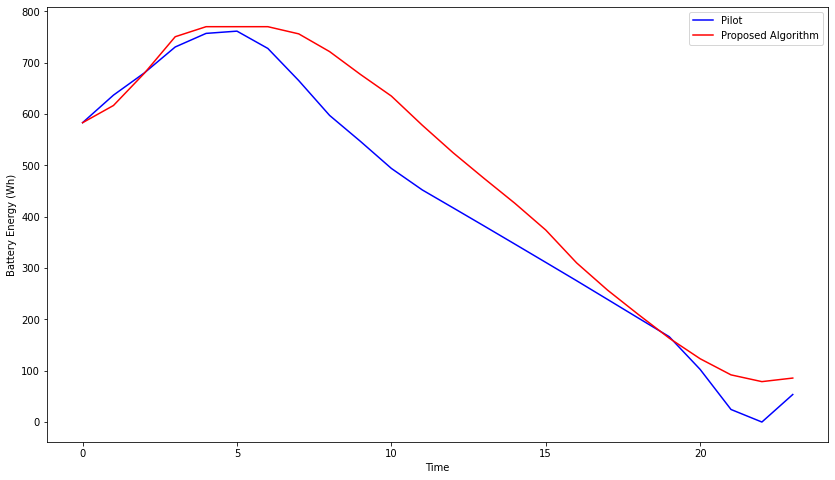

In [139]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))
h = [1]
for i in range(23):
  h.append((h[i] + 1)% 24)

plt.plot(hum_battery, color='b', label='Pilot')
plt.plot(alg_battery_forecast, color='r', label='Proposed Algorithm')
#plt.plot(wc_battery_forecast, color='g', label='Worse Case')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Time")
plt.ylabel("Battery Energy (Wh)")
plt.legend()
plt.show()

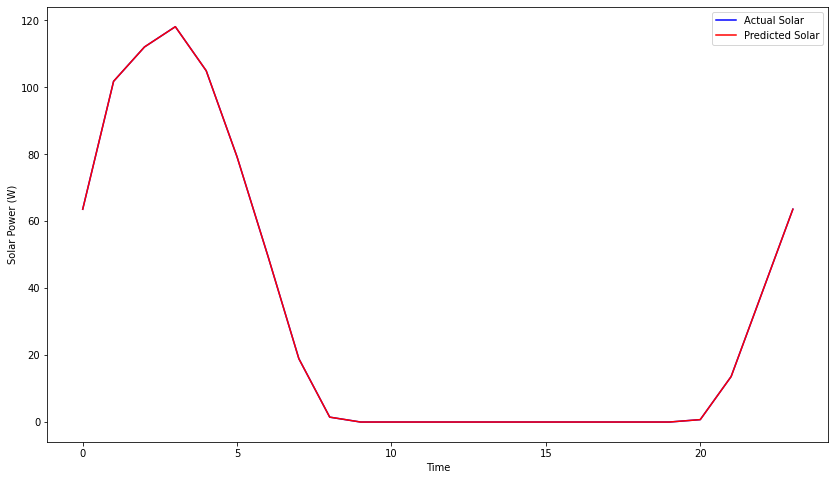

In [140]:
plt.figure(figsize=(14, 8))
plt.plot(hum_solar, color='b', label='Actual Solar')
hum_solar= data['solar'].to_numpy()
plt.plot(p_solar, color='r', label='Predicted Solar')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Time")
plt.ylabel("Solar Power (W)")
plt.legend()
plt.show()

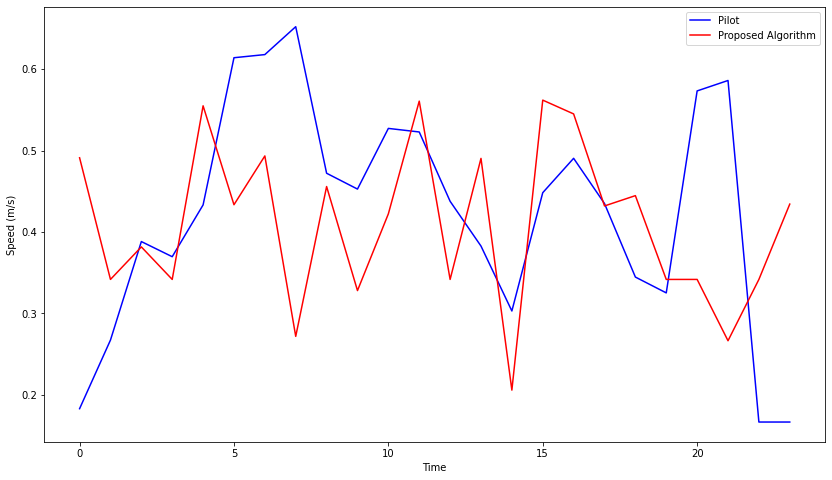

In [141]:
plt.figure(figsize=(14, 8))
h = [1]
for i in range(23):
  h.append((h[i] + 1)% 24)

plt.plot(hum_speed, color='b', label='Pilot')
plt.plot(alg_speed_forecast, color='r', label='Proposed Algorithm')
#plt.plot(wc_speed_forecast, color='g', label='Worse Case')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Time")
plt.ylabel("Speed (m/s)")
plt.legend()
plt.show()

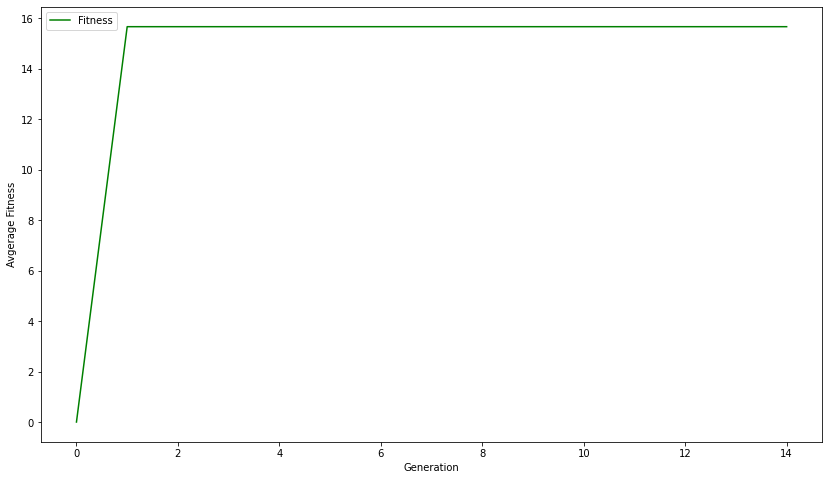

In [142]:
plt.figure(figsize=(14, 8))

plt.plot(fitness, color='g', label='Fitness')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Generation")
plt.ylabel("Avgerage Fitness")
plt.legend()
plt.show()

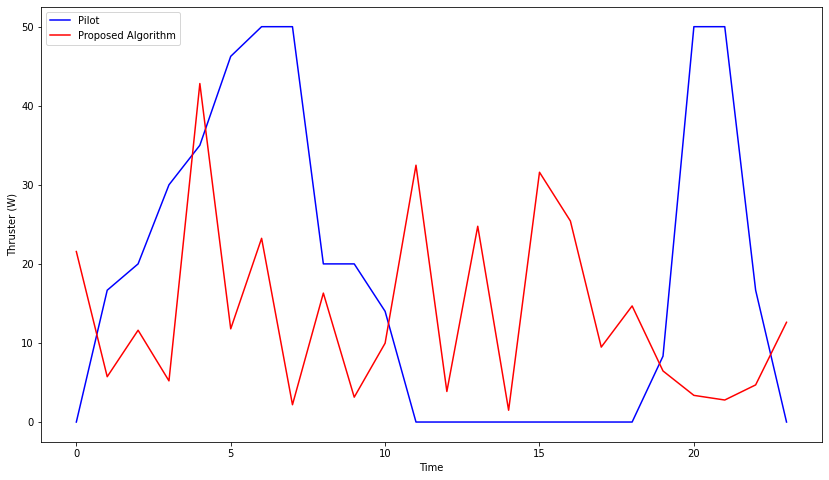

In [143]:
plt.figure(figsize=(14, 8))

plt.plot(hum_thruster, color='b', label='Pilot')
plt.plot(plan[0], color='r', label='Proposed Algorithm')
#plt.plot(plan_wc, color='g', label='Worse Case')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Time")
plt.ylabel("Thruster (W)")
plt.legend()
plt.show()